In [ ]:
# !pip install plotnine

In [ ]:
# !pip install --upgrade numexpr

In [ ]:
# !pip install --upgrade bottleneck

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import pyarrow.parquet as pq
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, precision_score

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
# from plotnine.themes import theme_538

In [2]:
def altair_conf_table(conf_df):
    # Convert the seaborn dataframe to a long-form dataframe suitable for Altair
    conf_df_i_long = pd.melt(conf_df.reset_index(), id_vars='index')

    # Altair heatmap without legend and axis titles
    heatmap = alt.Chart(conf_df_i_long).mark_rect().encode(
        x='variable:O',
        y='index:O',
        color=alt.Color('value:Q', scale=alt.Scale(scheme='blues'),legend=None),  # Set color scale directly
        tooltip=['value:N']
    ).properties(
        width=400,
        height=300,
        title="Confusion Matrix"
    )

    # Text layer to display the values in each cell with increased font size
    text = alt.Chart(conf_df_i_long).mark_text(baseline='middle', fontSize=16).encode(
        x='variable:O',
        y='index:O',
        text='value:Q'
    )

    # Combine the heatmap and text layers
    alt_chart = heatmap + text

    # Remove the color legend
    alt_chart = alt_chart.configure_legend(
        strokeColor='white',
        fillColor='#f5f5f5',
        padding=10,
        cornerRadius=10,
        orient='none',
        legendX=650,
        legendY=0,
        direction='horizontal',
        labelFont='Arial',
        labelFontSize=12,
        labelColor='gray',
        title=None
    )

    # Remove axis titles
    alt_chart = alt_chart.configure_axis(
        labelFontSize=12,
        title=None,
        labelAngle=0 
    )
    

    # Show the Altair chart without legend and axis titles
    return  alt_chart

In [3]:
warnings.filterwarnings("ignore")

# Data Collection

## RNAseq Expression Data

In [4]:
current_directory = os.getcwd()
current_directory

'/home/hermonpe/SIADS699/notebooks'

In [5]:
# Navigate to the parent directory
parent_directory = os.path.dirname(current_directory)
parent_directory

'/home/hermonpe/SIADS699'

In [6]:
# import gene RNAseq data file from a parquet formated file
table = pq.read_table(parent_directory+'/data/processed/merged_df.parquet')

In [7]:
# convert data table to a pandas data frame
merged_df = table.to_pandas()

In [8]:
# delete table to free memory
del table

In [9]:
# ispect the RNAseq dataframe
merged_df.head()

,499304660,499304661,499304662,499304663,499304664,499304665,499304666,499304667,499304668,499304669,...,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan
rnaseq_profile_id,,,,,,,,,,,,,,,,,,,,,
488395315,0.655725,4.526404,0.0,0.0,0.039654,0.0,0.0,0.0,0.0,0.317608,...,0,No Dementia,3,No Dementia,N,White,Not Hispanic,No Dementia,3,2
496100277,0.095143,8.855850,0.0,0.0,0.016492,0.0,0.0,0.0,0.0,0.955393,...,0,No Dementia,14,No Dementia,N,White,Not Hispanic,No Dementia,3,1
496100278,0.000000,4.868456,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.361740,...,2,No Dementia,2,No Dementia,Y,White,Not Hispanic,No Dementia,6,2
496100279,0.000000,4.851842,0.0,0.0,0.170431,0.0,0.0,0.0,0.0,1.357990,...,2,No Dementia,2,No Dementia,Y,White,Not Hispanic,No Dementia,6,2
496100281,0.000000,3.600344,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.005507,...,0,Alzheimer's Disease Type,2,Probable Alzheimer'S Disease,N,White,Not Hispanic,Dementia,1,1


## Gene Information

In [10]:
# gene information table
rows_genes = pd.read_csv(parent_directory+"/data/external/rows-genes.csv")
rows_genes = rows_genes.set_index('gene_id')
rows_genes.index = rows_genes.index.astype(int)
rows_genes

,chromosome,gene_entrez_id,gene_symbol,gene_name
gene_id,,,,
499304660,1,100287102,DDX11L1,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 l...
499304661,1,653635,WASH7P,WAS protein family homolog 7 pseudogene
499304662,1,102466751,MIR6859-1,microRNA 6859-1
499304663,1,100302278,MIR1302-2,microRNA 1302-2
499304664,1,645520,FAM138A,"family with sequence similarity 138, member A"
...,...,...,...,...
499355059,MT,4541,ND6,NADH dehydrogenase subunit 6
499355060,MT,4556,TRNE,tRNA-Glu
499355061,MT,4519,CYTB,cytochrome b


# Data Preprocessing

The data was process and tables were merged on the notebook named "data_import_transformation.ipynb"

## Prepare data for model training

In [11]:
# # assign X and y by selecting colunmns containing the gene features and predicted value
X = merged_df.iloc[:,:50281]
y = merged_df['act_demented']

## Split the Data

In [12]:
# assign X and y by selecting colunmns containing the gene features and predicted value
X = merged_df.iloc[:,:50281]
y = merged_df['act_demented']

In [13]:
# split the data into a training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale the Data

In [14]:
# Standardize the data
scaler = StandardScaler()

# standarize training and test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training

In [15]:
# Create and train the logistic regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

## Model Evaluation

In [16]:
pred_logreg = logreg_model.predict(X_test_scaled)
logreg_score = logreg_model.score(X_test_scaled, y_test)
print("Logistic regression: {:.2f}".format(logreg_score))

Logistic regression: 0.79


In [17]:
conf_matrix = confusion_matrix(y_test, pred_logreg)
conf_df = pd.DataFrame(conf_matrix, index=['Actual Dementia', 'Actual No Dementia'],
                       columns=['Predicted Dementia', 'Predicted No Dementia'])

print(conf_df)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, pred_logreg))

altair_conf_table(conf_df)


                    Predicted Dementia  Predicted No Dementia
Actual Dementia                     24                     11
Actual No Dementia                   5                     36
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.83      0.69      0.75        35
 No Dementia       0.77      0.88      0.82        41

    accuracy                           0.79        76
   macro avg       0.80      0.78      0.78        76
weighted avg       0.79      0.79      0.79        76



alt.LayerChart(...)

### Regularization Strength (C)

In [18]:
from sklearn.model_selection import GridSearchCV
# Define the logistic regression model
logreg_model = LogisticRegression()

# Define the hyperparameter grid for C
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='precision')
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameter value
best_C = grid_search.best_params_['C']
print(f"Best C value: {best_C}")

# Evaluate the model with the best hyperparameter on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_scaled, y_test)
print(f"Accuracy on test set with best C: {test_accuracy}")

Best C value: 0.001
Accuracy on test set with best C: 0.7631578947368421


In [19]:
best_model_pred = best_model.predict(X_test_scaled)
best_model_score = best_model.score(X_test_scaled, y_test)

conf_matrix = confusion_matrix(y_test, best_model_pred)
conf_df = pd.DataFrame(conf_matrix, index=['Actual Dementia', 'Actual No Dementia'],
                       columns=['Predicted Dementia', 'Predicted No Dementia'])

print(conf_df)

conf_df_i_long = pd.melt(conf_df.reset_index(), id_vars='index')

print(conf_df_i_long)

plt.style.use('ggplot')

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, best_model_pred))

altair_conf_table(conf_df)


                    Predicted Dementia  Predicted No Dementia
Actual Dementia                     21                     14
Actual No Dementia                   4                     37
                index               variable  value
0     Actual Dementia     Predicted Dementia     21
1  Actual No Dementia     Predicted Dementia      4
2     Actual Dementia  Predicted No Dementia     14
3  Actual No Dementia  Predicted No Dementia     37
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.84      0.60      0.70        35
 No Dementia       0.73      0.90      0.80        41

    accuracy                           0.76        76
   macro avg       0.78      0.75      0.75        76
weighted avg       0.78      0.76      0.76        76



alt.LayerChart(...)

### Feature Selection

In [20]:
model = best_model

In [21]:
feature_importance = model.coef_[0]

In [22]:
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

In [23]:
# Create a DataFrame or Series with feature names and their importance scores
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])
feature_importance_df

,Feature,Importance
0,499304660,-0.001249
1,499304661,-0.000334
2,499304662,0.000349
3,499304663,0.001220
4,499304664,-0.002135
...,...,...
50276,499355059,0.000841
50277,499355060,-0.001161
50278,499355061,0.001798
50279,499355062,-0.001029


In [24]:
# Set the 'Feature' column as the index
feature_importance_df.set_index('Feature', inplace=True)
feature_importance_df.index.name = 'gene_id'
feature_importance_df.index = feature_importance_df.index.astype(int)

# Display the feature importance DataFrame
print(feature_importance_df)

           Importance
gene_id              
499304660   -0.001249
499304661   -0.000334
499304662    0.000349
499304663    0.001220
499304664   -0.002135
...               ...
499355059    0.000841
499355060   -0.001161
499355061    0.001798
499355062   -0.001029
499355063    0.001866

[50281 rows x 1 columns]


In [25]:
rows_genes = pd.merge(rows_genes, feature_importance_df, left_index=True, right_index=True)

In [26]:
rows_genes

,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance
gene_id,,,,,
499304660,1,100287102,DDX11L1,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 l...,-0.001249
499304661,1,653635,WASH7P,WAS protein family homolog 7 pseudogene,-0.000334
499304662,1,102466751,MIR6859-1,microRNA 6859-1,0.000349
499304663,1,100302278,MIR1302-2,microRNA 1302-2,0.001220
499304664,1,645520,FAM138A,"family with sequence similarity 138, member A",-0.002135
...,...,...,...,...,...
499355059,MT,4541,ND6,NADH dehydrogenase subunit 6,0.000841
499355060,MT,4556,TRNE,tRNA-Glu,-0.001161
499355061,MT,4519,CYTB,cytochrome b,0.001798


In [27]:
# Export complet set of genes
rows_genes.to_csv(parent_directory+'/results/tables/all_genes_table.csv')

In [28]:
# Select features
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)
feature_importance_df

,Importance
gene_id,
499328351,0.006306
499342498,0.005048
499336276,0.004684
499305157,0.004535
499351898,0.004525
...,...
499309559,-0.004572
499329196,-0.004594
499313799,-0.004743


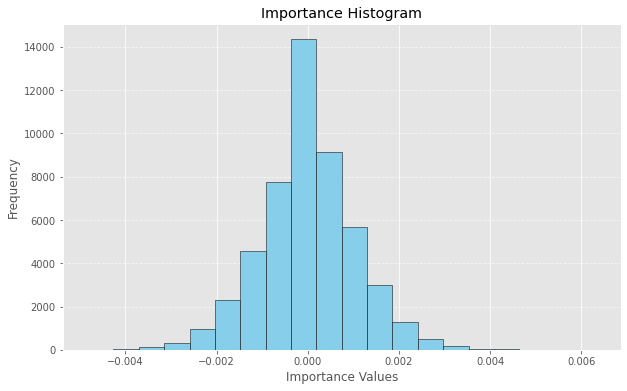

In [29]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(feature_importance_df['Importance'], bins=20, color='skyblue', edgecolor='black')
plt.title('Importance Histogram')
plt.xlabel('Importance Values')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Feature Importance

Removing irrelevant or highly correlated features

In [30]:
from sklearn.feature_selection import SelectFromModel

# set the number of features
max_features = 5000
selector = SelectFromModel(model, threshold=-np.inf, max_features=max_features)

In [31]:
# how many columns at thies point

In [32]:
X_train_scaled.shape

(301, 50281)

In [33]:
selector.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.001), max_features=5000,
                threshold=-inf)

In [34]:
# Get the boolean mask of selected features
feature_mask = selector.get_support()

In [35]:
# Use boolean indexing to select the indexes
selected_indexes = feature_names[feature_mask]

In [36]:
selected_indexes

Index(['499304664', '499304666', '499304667', '499304671', '499304686',
       '499304688', '499304698', '499304700', '499304703', '499304714',
       ...
       '499354979', '499354987', '499355004', '499355018', '499355022',
       '499355033', '499355050', '499355057', '499355061', '499355063'],
      dtype='object', length=5000)

In [37]:
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

In [38]:
model.fit(X_train_selected, y_train)

LogisticRegression(C=0.001)

In [39]:
%%time
# Perform RFE with cross-validation

# Specify the positive class label
positive_class_label = 'Dementia'

# Create a scorer for precision with the specified positive label
precision_scorer = make_scorer(precision_score, pos_label=positive_class_label)
cv = StratifiedKFold(n_splits=5)

# Use the precision_scorer in RFECV
rfe = RFECV(estimator=model, step=1, cv=cv, scoring=precision_scorer)

CPU times: user 25 µs, sys: 24 µs, total: 49 µs
Wall time: 55.8 µs


In [40]:
%%time
rfe.fit(X_train_selected, y_train)

CPU times: user 36min 39s, sys: 45min 18s, total: 1h 21min 57s
Wall time: 24min 6s


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=0.001),
      scoring=make_scorer(precision_score, pos_label=Dementia))

In [41]:
# Get the optimal number of features
optimal_num_features = rfe.n_features_

In [42]:
optimal_num_features

3622

In [43]:
len(rfe.support_)

5000

In [44]:
optimal_features_mask = rfe.support_

In [45]:
optimal_features = selected_indexes[optimal_features_mask]

In [46]:
# Get the list of selected features
optimal_features

Index(['499304664', '499304666', '499304667', '499304686', '499304698',
       '499304700', '499304714', '499304734', '499304747', '499304764',
       ...
       '499354942', '499354952', '499354960', '499354964', '499354975',
       '499354987', '499355004', '499355018', '499355022', '499355061'],
      dtype='object', length=3622)

In [47]:
 # Save the array to a file
np.save(parent_directory+'/results/plots/selected_features.npy', optimal_features)

In [48]:
# Create a DataFrame to store the data
results_df = pd.DataFrame({
    'Number_of_Features': range(1, len(rfe.grid_scores_) + 1),
    'Cross_Validated_Score': rfe.grid_scores_
})

In [49]:
results_df

,Number_of_Features,Cross_Validated_Score
0,1,0.300000
1,2,0.783333
2,3,0.660714
3,4,0.683333
4,5,0.816429
...,...,...
4995,4996,1.000000
4996,4997,1.000000
4997,4998,1.000000
4998,4999,1.000000


In [50]:
# Save feature importance externally
results_df.to_csv(parent_directory+'/results/plots/rfe_cv_results.csv')

In [51]:
# Print the recommendations
print(f"Optimal Number of Features: {optimal_num_features}")
# print(f"Selected Features: {list(selected_features)}")

Optimal Number of Features: 3622


#### Plot RFE from external file

In [52]:
results_df_ext = pd.read_csv(parent_directory+'/results/plots/rfe_cv_results.csv')

In [53]:
results_df_ext.head()

,Unnamed: 0,Number_of_Features,Cross_Validated_Score
0,0,1,0.300000
1,1,2,0.783333
2,2,3,0.660714
3,3,4,0.683333
4,4,5,0.816429



__Recursive Feature Elimination with Cross-Validation__  
The plot (RFE-CV) shows the relationship between the number of selected features and the cross-validated score (accuracy in this case). Here's how to interpret the plot:

* X-axis (Number of Features Selected):  
Each point on the x-axis represents the number of features selected during the RFE process. It starts from 1 and goes up to the total number of features in your dataset.  
* Y-axis (Cross-Validated Score):  
The y-axis represents the cross-validated score (accuracy in this case) corresponding to the number of features selected. The higher the y-value, the better the model's performance.  

* Plot Shape:  
The elbow or plateau in the plot is the point where adding more features doesn't significantly improve the cross-validated score. We want to find a balance between the number of features and the model's performance.  


In [54]:
# Assuming 'results_df_ext' is your DataFrame


alt.themes.enable("fivethirtyeight")

# Create Altair chart with attribute syntax
chart = alt.Chart(data=results_df_ext, width=600).mark_line(point=True)

chart = chart.encode(
    x=alt.X('Number_of_Features:O', 
            axis=alt.Axis(ticks=True, labels=True, 
                          values=list(range(0, max_features+1, 100)), 
                          title='Number of Features',
                          grid=True,  # Show gridlines
                          domain=False,  # Hide x-axis line
                          labelAlign='right',  # Align labels to the right for better readability
                          labelPadding=0,  # Add padding to labels
                          tickMinStep=100)  # Set the interval between ticks
           ),
    y=alt.Y('Cross_Validated_Score:Q',
           axis=alt.Axis(title='Cross Validation Score')),
    tooltip=['Number_of_Features:O', 'Cross_Validated_Score:Q']
)

chart = chart.properties(
    title='Recursive Feature Elimination with Cross-Validation (RFE-CV)'  # Add the title here
)

# Add a vertical red line to represent optimal_num_features
red_line = alt.Chart(pd.DataFrame({'x': [optimal_num_features]})).mark_rule(color='red').encode(x='x:O')

# Combine the main chart and the red line
combined_chart = chart + red_line

# Show the chart
combined_chart

alt.LayerChart(...)

#### Most important features

In [55]:
# read selected features
optimal_features = np.load(parent_directory+'/results/plots/selected_features.npy' , allow_pickle=True)

In [56]:
# convert index key to integers for feature matching
optimal_features = optimal_features.astype(int)

In [57]:
# merge selected features with gene information data
selected_rows = rows_genes [rows_genes .index.isin(optimal_features)]

In [58]:
# inspect selected gene rows/features
selected_rows

,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance
gene_id,,,,,
499304664,1,645520,FAM138A,"family with sequence similarity 138, member A",-0.002135
499304666,1,79504,OR4G4P,"olfactory receptor, family 4, subfamily G, mem...",-0.003320
499304667,1,403263,OR4G11P,"olfactory receptor, family 4, subfamily G, mem...",-0.002772
499304686,1,105378947,LOC105378947,proline-rich extensin-like protein EPR1,-0.003186
499304698,1,105378580,LOC105378580,uncharacterized LOC105378580,0.001795
...,...,...,...,...,...
499354987,Y,100418739,DNM1P48,DNM1 pseudogene 48,-0.002402
499355004,Y,386744,CDY22P,"chromodomain protein, Y-linked 22 pseudogene",-0.003050
499355018,Y,360188,CYCSP48,"cytochrome c, somatic pseudogene 48",0.002175


In [59]:
# Export selected genes table
selected_rows.to_csv(parent_directory+'/results/tables/selected_genes.csv')

## Model performace with reduced selcted features

Let's compare how a model trained with all features performs when conpared with a model that was only trained with the selected features based on RFS

In [60]:
X_train_prime = X_train[optimal_features.astype(str)]
X_test_prime = X_test[optimal_features.astype(str)]

In [61]:
# Standardize the data
scaler = StandardScaler()

# standarize training and test set
X_train_i_scaled = scaler.fit_transform(X_train_prime)
X_test_i_scaled = scaler.transform(X_test_prime)

In [62]:
# Create and train the logistic regression model
logreg_model_i = LogisticRegression(random_state=42 ,C=0.001 )

In [63]:
logreg_model_i.fit(X_train_i_scaled, y_train)

pred_logreg_i = logreg_model_i.predict(X_test_i_scaled)
logreg_score_i = logreg_model_i.score(X_test_i_scaled, y_test)
print("Logistic regression: {:.2f}".format(logreg_score_i))

Logistic regression: 0.79


In [64]:
conf_matrix_i = confusion_matrix(y_test, pred_logreg_i)
conf_df_i = pd.DataFrame(conf_matrix_i, index=['Actual Dementia', 'Actual No Dementia'],
                       columns=['Predicted Dementia', 'Predicted No Dementia'])

print(conf_df_i)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, pred_logreg_i))

alt.themes.enable("default")
altair_conf_table(conf_df_i)


                    Predicted Dementia  Predicted No Dementia
Actual Dementia                     25                     10
Actual No Dementia                   6                     35
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.81      0.71      0.76        35
 No Dementia       0.78      0.85      0.81        41

    accuracy                           0.79        76
   macro avg       0.79      0.78      0.79        76
weighted avg       0.79      0.79      0.79        76



alt.LayerChart(...)

### Solver

In [65]:
# ### Solver

# Define the solvers you want to compare
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

# Initialize an empty dictionary to store the mean cross-validation scores for each solver
mean_scores = {}

# Loop through each solver and calculate the mean cross-validation score
for solver in solvers:
    model = LogisticRegression(random_state=42,C=0.001,solver=solver)
                               
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # You can use other scoring metrics as well
    mean_scores[solver] = np.mean(scores)

In [ ]:
# Print mean scores for each solver
for solver, mean_score in mean_scores.items():
    print(f'{solver}: {mean_score}')

# Choose the solver with the highest mean score
best_solver = max(mean_scores, key=mean_scores.get)
print(f'Best Solver: {best_solver}')

# Model

In [ ]:
logreg_model = LogisticRegression(random_state=42 ,C=0.001, solver='lbfgs' )

In [ ]:
logreg_model.fit(X_train_i_scaled, y_train)

## Features

In [ ]:
selected_rows

## Discusion

Regarding long-term care insurance underwriting, our primary goal is to enhance the accuracy of predicting No Dementia in patients while minimizing false positives. The original model, which uses over 50,000 features, has a greater precision of 0.85 for No Dementia, indicating that 85% of patients identified as No Dementia are accurate. In contrast, the new model has a precision of approximately 0.76 for No Dementia, meaning that around 76% of instances predicted as No Dementia are true negatives.
Although the new model correctly identifies more true negatives (35 out of 41) than the original model (34 out of 41), the precision metric considers the ratio of true negatives to false positives. The original model achieves a higher precision in predicting No Dementia, indicating a lower occurrence of false positives.
It's important to acknowledge that despite utilizing only 283 features or the expression of 283 genes, the new model achieves a comparable specificity for predicting No Dementia. This reduction in feature dimensionality has practical implications, such as reduced computational costs and improved model interpretability.
Furthermore, the possibility of obtaining gene expression data on 283 targeted genes using faster chip technology, such as customized microarrays or targeted RNA sequencing panels, is worth investigating. These technologies allow for high-throughput analysis, offering opportunities for more efficient and streamlined processes.

## Libraries

In [ ]:
import pkg_resources

def get_library_versions():
    # List of libraries used in the project
    libraries = ['pandas', 'numpy', 'altair', 'pyarrow', 'scikit-learn', 'seaborn', 'matplotlib', 'warnings']

    # Dictionary to store library versions
    library_versions = {}

    # Iterate through the list of libraries and get their versions
    for library in libraries:
        try:
            version = pkg_resources.get_distribution(library).version
            library_versions[library] = version
        except pkg_resources.DistributionNotFound:
            library_versions[library] = "Not Installed"

    return library_versions

if __name__ == "__main__":
    versions = get_library_versions()

    # Print the library versions
    print("Library Versions:")
    for library, version in versions.items():
        print(f"{library}: {version}")